In [1]:
from itertools import compress
import pandas as pd
import re
import numpy as np
import keras
from keras import layers
from keras.layers import recurrent, Dense, Input, LSTM, concatenate, Reshape
from keras.models import Model
import matplotlib.pyplot as plt
from keras import backend as K

Using TensorFlow backend.


In [2]:
pd.options.display.max_rows = 10

pd.options.display.max_rows

10

In [3]:
df = pd.read_csv('/home/david/stockPortfolioGen/data/stocks.csv.gz', compression='gzip')

In [4]:
df = df.sort_values(by=['Date', 'Symbol'])

In [5]:
# l1 = list(range(1,10+1))

# l2 = [list(range(i, i+10)) for i in l1]
# l2 = np.array(l2)

# l2.shape
# l2

In [6]:
# stocks = list(df['Symbol'].unique())
# stocks = stocks[0:2]

# print(stocks)

# train_arr = np.empty((0,37)) 

# for stock in stocks:
#    df_stock = df[df['Symbol'] == stock]
#    np_stock = np.array(df_stock['Adj Close'])
#    array_stock = [np_stock[range(min(i, len(np_stock)), min(i + 37, len(np_stock)))] for i in range(len(df_stock['Adj Close']))]
#    array_stock = np.array(array_stock)
#    print(array_stock.shape)
#    np.append(train_arr, array_stock, axis = 0)

# train_arr

In [7]:
# ind = pd.Series(df['Symbol']).str.contains('aapl').tolist()
# df[ind]

In [8]:
# I don't have the NYSE ? Missing CHS and AAPL.
# dat = df[df['Symbol']=='CASI']
ind = (df['Symbol']=='CASI')|(df['Symbol']=='MSFT')|(df['Symbol']=='MBOT')|(df['Symbol']=='TLRY')|(df['Symbol']=='GOOG')

# dat = df[ind].pivot(index = 'Date', columns = 'Symbol', values = 'Adj Close').fillna(0)
dat = df[ind]

In [9]:
dat2 = dat.drop(dat.columns[[0,2]], axis = 1)
firsts = dat2.groupby('Symbol').transform('first')
normalized = dat2.drop(dat2.columns[[0]], axis = 1)/firsts

dat = dat.loc[:,"Symbol":"Date"].join(normalized)
dat

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
694044,CASI,2008-12-22,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
173173,GOOG,2008-12-22,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2699343,MBOT,2008-12-22,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2704371,MSFT,2008-12-22,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
694045,CASI,2008-12-23,0.842105,0.950000,1.000000,0.888889,0.888889,0.886010
...,...,...,...,...,...,...,...,...
696557,CASI,2018-12-17,2.033493,2.040909,2.409091,2.176768,2.176768,10.031425
175686,GOOG,2018-12-17,6.768590,6.849756,6.981078,6.887292,6.887292,0.302145
2701856,MBOT,2018-12-17,0.001428,0.001403,0.001389,0.001356,0.001356,46.357692
2706884,MSFT,2018-12-17,5.478690,5.484707,5.384331,5.364442,6.873662,0.972285


In [10]:
log_trans = dat.drop(dat.columns[[1]], axis = 1).groupby('Symbol').transform(np.log)
dat = dat.loc[:,"Symbol":"Date"].join(log_trans)

dat

/home/david/.local/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4477: RuntimeWarning: divide by zero encountered in log
  lambda x: func(x, *args, **kwargs), axis=self.axis)
/home/david/.local/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4475: RuntimeWarning: divide by zero encountered in log
  fast_path = lambda group: func(group, *args, **kwargs)


,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
694044,CASI,2008-12-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
173173,GOOG,2008-12-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2699343,MBOT,2008-12-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2704371,MSFT,2008-12-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
694045,CASI,2008-12-23,-0.171850,-0.051293,0.000000,-0.117783,-0.117783,-0.121027
...,...,...,...,...,...,...,...,...
696557,CASI,2018-12-17,0.709755,0.713395,0.879249,0.777841,0.777841,2.305723
175686,GOOG,2018-12-17,1.912293,1.924213,1.943203,1.929678,1.929678,-1.196850
2701856,MBOT,2018-12-17,-6.551224,-6.569201,-6.579251,-6.603544,-6.603544,3.836387
2706884,MSFT,2018-12-17,1.700866,1.701964,1.683493,1.679792,1.927697,-0.028107


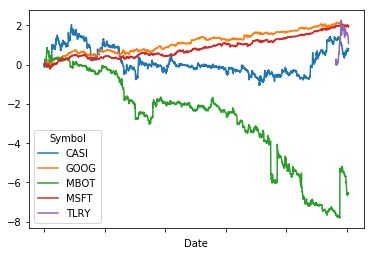

In [11]:
dat.pivot_table(index='Date',columns='Symbol',values='Adj Close',aggfunc='sum').plot()

In [12]:
dat = dat.pivot(index = 'Date', columns = 'Symbol', values = 'Adj Close').fillna(0)
dat

Symbol,CASI,GOOG,MBOT,MSFT,TLRY
Date,,,,,
2008-12-22,0.000000,0.000000,0.000000,0.000000,0.000000
2008-12-23,-0.117783,0.003058,-0.024293,0.005200,0.000000
2008-12-24,-0.057158,0.019465,0.023717,-0.000521,0.000000
2008-12-26,0.105361,0.010879,0.106160,-0.002610,0.000000
2008-12-29,-0.057158,0.001043,0.069526,-0.011536,0.000000
...,...,...,...,...,...
2018-12-11,0.672738,1.963738,-6.519725,1.981616,1.435425
2018-12-12,0.777841,1.975018,-6.509725,1.986118,1.327900
2018-12-13,0.768517,1.973343,-6.529826,1.989504,1.215783


In [13]:
dat = dat.stack().reset_index()
dat.columns = ['Date', 'Symbol', 'Adj Close']

In [14]:
new_cols = pd.get_dummies(dat['Symbol'])

dat = pd.DataFrame(dat['Adj Close']).join(new_cols)
# index contains duplicates..(index = Date)
dat

,Adj Close,CASI,GOOG,MBOT,MSFT,TLRY
0,0.000000,1,0,0,0,0
1,0.000000,0,1,0,0,0
2,0.000000,0,0,1,0,0
3,0.000000,0,0,0,1,0
4,0.000000,0,0,0,0,1
...,...,...,...,...,...,...
12565,0.777841,1,0,0,0,0
12566,1.929678,0,1,0,0,0
12567,-6.603544,0,0,1,0,0
12568,1.927697,0,0,0,1,0


In [15]:
# print("stuck here") not stuck anymore

In [16]:
# dat.head()
# normalizer = dat['Adj Close'].tolist()[0:1]
# normalizer
#normalizer = dat.ix[0]
#print(normalizer)
# dat = dat.loc[:,"CASI":"TLRY"].div(dat.ix[0]).fillna(0)

In [17]:
# need to do refer to this: https://keras.io/getting-started/functional-api-guide/

In [18]:
## indexes to delete since symbols don't match
# dfx = dat[0:10055].loc[:, "CASI":"TLRY"]
# dfy = dat[1:10056].loc[:, "CASI":"TLRY"]
# rm_i = (np.sum((np.array(dfx) == np.array(dfy)), axis = 1) > 3).tolist()
# list(compress(rm_i, [not i for i in rm_i]))

In [19]:
dat

,Adj Close,CASI,GOOG,MBOT,MSFT,TLRY
0,0.000000,1,0,0,0,0
1,0.000000,0,1,0,0,0
2,0.000000,0,0,1,0,0
3,0.000000,0,0,0,1,0
4,0.000000,0,0,0,0,1
...,...,...,...,...,...,...
12565,0.777841,1,0,0,0,0
12566,1.929678,0,1,0,0,0
12567,-6.603544,0,0,1,0,0
12568,1.927697,0,0,0,1,0


In [20]:
print(str(0)+":"+str((dat.shape[0]-dat.shape[1])))
print(str(dat.shape[1]-1)+":"+str(dat.shape[0]-1))
x = np.array(dat[0:(dat.shape[0]-dat.shape[1])])
print(x)
y = np.array(dat[(dat.shape[1]-1):(dat.shape[0]-1)])
print(y)

0:12564
5:12569
[[ 0.          1.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.        ]
 ...
 [ 1.95452091  0.          1.          0.          0.          0.        ]
 [-6.52476303  0.          0.          1.          0.          0.        ]
 [ 1.95775864  0.          0.          0.          1.          0.        ]]
[[-1.17783036e-01  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.05824033e-03  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.42927108e-02  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.92967792e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.60354390e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.92769702e+00 

In [21]:
print(x.shape)
print(y.shape)

(12564, 6)
(12564, 6)


In [22]:
# rm_i = pd.Series(rm_i)

# x = dat[0:10055]
# y = dat[1:10056]

# x = np.array(x[rm_i.values])
# y = np.array(y[rm_i.values])

print(x.shape)
print(y.shape)

(12564, 6)
(12564, 6)


In [23]:
x = x.reshape(x.shape[0], 1, 6)
x.shape

(12564, 1, 6)

In [24]:
x_values = x[:,:,0:1]
y = y[:,0:1]
x_symb = x[:,0,1:6]

In [25]:
print(x_values.shape)
print(x_symb.shape)
print(y.shape)
print(x_symb.shape[1:2])

(12564, 1, 1)
(12564, 5)
(12564, 1)
(5,)


(array([ 299.,   95.,  210.,   90.,  252.,  865.,  117., 4745., 3727.,
        2164.]),
 array([-7.80569687, -6.79936299, -5.79302911, -4.78669522, -3.78036134,
        -2.77402746, -1.76769358, -0.76135969,  0.24497419,  1.25130807,
         2.25764195]),
 <a list of 10 Patch objects>)

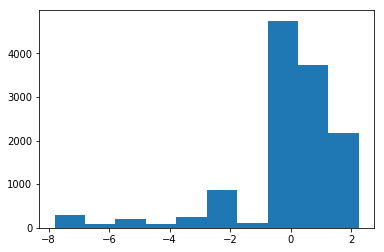

In [26]:
plt.hist(x_values[:,0,0])

(array([ 299.,   96.,  210.,   90.,  252.,  865.,  117., 4740., 3729.,
        2166.]),
 array([-7.80569687, -6.79936299, -5.79302911, -4.78669522, -3.78036134,
        -2.77402746, -1.76769358, -0.76135969,  0.24497419,  1.25130807,
         2.25764195]),
 <a list of 10 Patch objects>)

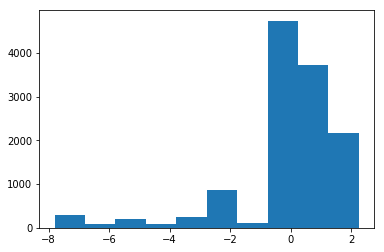

In [27]:
plt.hist(y[:,0])

In [28]:
# from keras import backend as K
# K.clear_session()

In [29]:
LSTM_cell = LSTM(1, return_state = True)
densor_a = Dense(1, activation = 'linear', name = 'lstm_output')
densor_b = Dense(5, activation = 'relu')
densor_c = Dense(1, activation = 'linear', name = 'main_output')

In [30]:
main_input = Input(shape = x_values.shape[1:3], name = 'main_input')
aux_input = Input(shape = (x_symb.shape[1:2]), name = 'aux_input')
print(main_input)
print(aux_input)

a,_,c = LSTM_cell(main_input)
# print(lstm)
lstm_out = densor_a(a)
# print(lstm_out)
concat = concatenate([lstm_out, aux_input])
# print(concat)
dense = densor_b(concat)
# print(dense)
main_output = densor_c(dense)
# print(main_output)

Tensor("main_input:0", shape=(?, 1, 1), dtype=float32)
Tensor("aux_input:0", shape=(?, 5), dtype=float32)


In [31]:
model = Model(inputs=[main_input, aux_input], outputs=[main_output, lstm_out])
print(model)

In [32]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
print(model)

In [33]:
# need to understand why this is creating nans

# need to create separate validation set
for i in range(20): # can create a function instead, if prefer
        model.fit(x = [x_values, x_symb], y = [y, y], epochs = 1, batch_size = 4) # use batch size 1 for each day
        model.reset_states()

Epoch 1/1
12564/12564 [==============================] - 7s 568us/step - loss: 3.6328 - main_output_loss: 1.0395 - lstm_output_loss: 2.5933
Epoch 1/1
12564/12564 [==============================] - 7s 527us/step - loss: 2.1458 - main_output_loss: 0.1432 - lstm_output_loss: 2.0026
Epoch 1/1
12564/12564 [==============================] - 7s 525us/step - loss: 1.5887 - main_output_loss: 0.1349 - lstm_output_loss: 1.4538
Epoch 1/1
12564/12564 [==============================] - 7s 527us/step - loss: 1.1363 - main_output_loss: 0.1279 - lstm_output_loss: 1.0084
Epoch 1/1
12564/12564 [==============================] - 7s 523us/step - loss: 0.7773 - main_output_loss: 0.1075 - lstm_output_loss: 0.6698
Epoch 1/1
12564/12564 [==============================] - 7s 519us/step - loss: 0.5075 - main_output_loss: 0.0792 - lstm_output_loss: 0.4283
Epoch 1/1
12564/12564 [==============================] - 7s 518us/step - loss: 0.3083 - main_output_loss: 0.0490 - lstm_output_loss: 0.2593
Epoch 1/1
12564/1256

In [34]:
model

In [35]:
print(x_values.shape)
print(dat.shape)
print(dat)

(12564, 1, 1)
(12570, 6)
       Adj Close  CASI  GOOG  MBOT  MSFT  TLRY
0       0.000000     1     0     0     0     0
1       0.000000     0     1     0     0     0
2       0.000000     0     0     1     0     0
3       0.000000     0     0     0     1     0
4       0.000000     0     0     0     0     1
...          ...   ...   ...   ...   ...   ...
12565   0.777841     1     0     0     0     0
12566   1.929678     0     1     0     0     0
12567  -6.603544     0     0     1     0     0
12568   1.927697     0     0     0     1     0
12569   1.079372     0     0     0     0     1

[12570 rows x 6 columns]


In [36]:
print(x_symb.shape)
print(x_symb)
print(x_symb[:,1])
print(x_symb[:,1]==1)

(12564, 5)
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
[0. 1. 0. ... 1. 0. 0.]
[False  True False ...  True False False]


In [37]:
pred = model.predict([x_values, x_symb])

In [38]:
pred

[array([[-1.0793434e-02],
        [ 3.2546059e-03],
        [-4.3578609e-03],
        ...,
        [ 1.9662027e+00],
        [-6.5629621e+00],
        [ 1.9722036e+00]], dtype=float32), array([[-1.0724068e-03],
        [-1.0724068e-03],
        [-1.0724068e-03],
        ...,
        [ 1.9475894e+00],
        [-6.5119429e+00],
        [ 1.9508166e+00]], dtype=float32)]

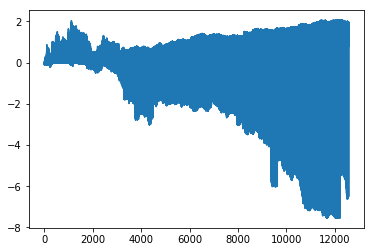

In [39]:
plt.plot(np.array(range(len(pred[1]))), pred[1])

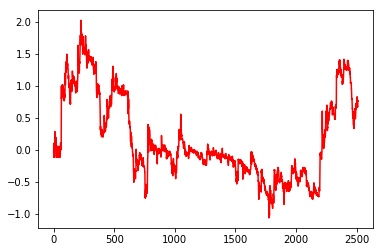

In [40]:
stock_i = 0

plt.plot(np.array(range(len(pred[1][x_symb[:,stock_i]==1]))), pred[1][x_symb[:,stock_i]==1], color = 'red')

In [41]:
dat

,Adj Close,CASI,GOOG,MBOT,MSFT,TLRY
0,0.000000,1,0,0,0,0
1,0.000000,0,1,0,0,0
2,0.000000,0,0,1,0,0
3,0.000000,0,0,0,1,0
4,0.000000,0,0,0,0,1
...,...,...,...,...,...,...
12565,0.777841,1,0,0,0,0
12566,1.929678,0,1,0,0,0
12567,-6.603544,0,0,1,0,0
12568,1.927697,0,0,0,1,0


In [42]:
# test = Input(shape=(1, 1))
# a0 = Input(shape=(1,), name='a0')
# c0 = Input(shape=(1,), name='c0')
# LSTM_cell(test, initial_state = [a0, c0])

In [43]:
## why does that work^ how to parse out a and c?

In [44]:
reshaper = Reshape((1,1))

In [45]:
main0 = Input(shape=(1, 1))
aux0 = Input(shape=(5,))

# Define s0, initial hidden state for the decoder LSTM
a0 = Input(shape=(1,), name='a0')
c0 = Input(shape=(1,), name='c0')

a = a0
c = c0
main = main0
aux = aux0

# print("main: " + str(K.int_shape(main)))

predictions = []


# # do i need a lambda function?
for i in range(40):

    a, _, c = LSTM_cell(main, initial_state = [a,c])
    # print("a: " + str(K.int_shape(a)))
    # print("c: " + str(K.int_shape(c)))
    lstm_output2 = Dense(1, activation='relu', name='lstm_output2')(a)
    # print("lstm_output2: " + str(K.int_shape(lstm_output2)))
    concat2 = concatenate([lstm_output2, aux])
    # print("concat2: " + str(K.int_shape(concat2)))
    dense = Dense(5, activation='relu', name='relu_output')(concat2)
    # print("dense: " + str(K.int_shape(dense)))
    main_output2 = Dense(1, activation='linear', name='main_output')(dense)
    # print("main_output2: " + str(K.int_shape(main_output2)))
    predictions.append(main_output2)
    main = reshaper(main_output2)
    print("main: " + str(main))
    ## need to reshape this

main: Tensor("reshape_1/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_1/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_2/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_3/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_4/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_5/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_6/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_7/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_8/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_9/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_10/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_11/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_12/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("reshape_1_13/Reshape:0", shape=(?, 1, 1), dtype=float32)
main: Tensor("resh

In [60]:
model2 = Model(inputs = [main0, aux0], outputs = predictions)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("a0:0", shape=(?, 1), dtype=float32) at layer "a0". The following previous layers were accessed without issue: ['input_1']

In [55]:
pred2 = model.predict([x_values, x_symb])

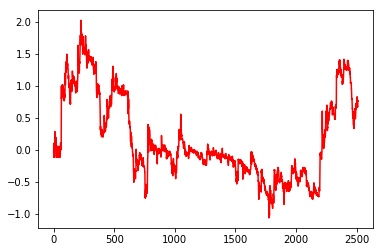

In [58]:
stock_i = 0

plt.plot(np.array(range(len(pred2[1][x_symb[:,stock_i]==1]))), pred2[1][x_symb[:,stock_i]==1], color = 'red')